# QM9 Pro.
Not sure what I’m supposed to call this file.  
Plan is to keep this repo much neater than before.  
Getting to work now.

In [51]:
import torch_geometric
import torch
from torch.nn import ModuleList, Module, Sequential, Embedding, Linear, BatchNorm1d, GELU, MSELoss
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_schedulerco
from typing import Any
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.pool import global_mean_pool
from torch_geometric.datasets import QM9
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
import wandb

In [52]:
wandb.login()
torch.manual_seed(2002)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sharshe. Use `wandb login --relogin` to force relogin


In [53]:
dataset = QM9(root='QM9/')

/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch_geometric/data/dataset.py:242: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, pass `force_reload=True` explicitly to reload the dataset.
  warnings.warn(


In [49]:
config_1 = {
    "base_learning_rate": 1e-3,
    "architecture": "Sparse 2-layer MPNN",
    "optimizer": "Adam",
    "scheduler": "ReduceLROnPlateau",
    "dataset": "QM9",
    "epochs": 10,
    "batch_size": 128,
}

config_2 = {
    "base_learning_rate": 1e-3,
    "architecture": "Sparse 2-layer MPNN",
    "optimizer": "Adam",
    "scheduler": "COSINEANNEALINGLR",
    "dataset": "QM9",
    "epochs": 10,
    "batch_size": 128,
}

config_3 = {
    "base_learning_rate": 1e-3,
    "architecture": "x",
    "optimizer": "Adam",
    "scheduler": "ReduceLROnPlateau",
    "dataset": "QM9",
    "epochs": 10,
    "batch_size": 128,
}

config_4 = {
    "base_learning_rate": 1e-3,
    "architecture": "x",
    "optimizer": "Adam",
    "scheduler": "COSINEANNEALINGLR",
    "dataset": "QM9",
    "epochs": 10,
    "batch_size": 128,
}

In [143]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network class with 3 convolutional layers and a linear layer"""

    def __init__(self):
        """init method for GCN"""
        self.emb_dim = 32
        super().__init__()
        
        self.embedding = Embedding(118, self.emb_dim)
        self.conv1 = GCNConv(self.emb_dim, self.emb_dim)
        self.conv2 = GCNConv(self.emb_dim, self.emb_dim)
        self.lin1 = torch.nn.Linear(self.emb_dim, 8)
        self.lin2 = torch.nn.Linear(8, 1)

    def forward(self, data):
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        x = data.x

        x = self.embedding(x)
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        
        return x

In [144]:
model = GCN()

In [155]:
dataloader_1000 = DataLoader(dataset[:12800], batch_size=128, shuffle=True)

In [156]:
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=0.0001)

losses = []
for data in dataloader_1000:
    optimizer.zero_grad()
    y_pred = model(data)
    loss = loss_fn(y_pred, data.y)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([2034, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([2028, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([2035, 1])). This will likely lead

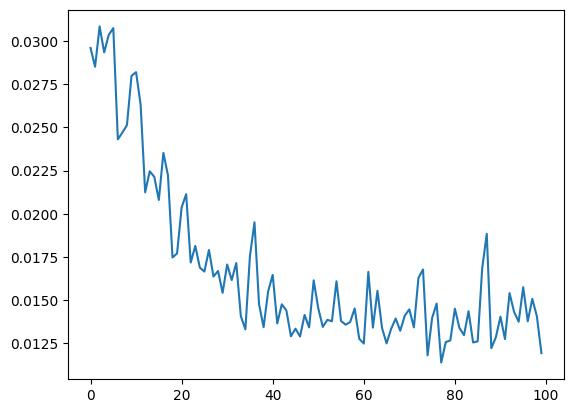

In [157]:
from matplotlib import pyplot
pyplot.plot(losses)

In [61]:
wandb.init(
    project="QM9-Pro",
    config = config_1
)

# train

wandb.finish()

NameError: name 'config_1' is not defined

In [91]:
from typing import Optional

import torch
from torch import Tensor

import torch_geometric.typing
from torch_geometric.typing import torch_scatter

src = torch.randn(10, 6, 64)

# Broadcasting in the first and last dim.
src.scatter_add(dim=-1)

TypeError: scatter_add() received an invalid combination of arguments - got (dim=int, ), but expected one of:
 * (int dim, Tensor index, Tensor src)
 * (name dim, Tensor index, Tensor src)
